In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

def rotate_xticklabels(ax, rot=45, ha='right'):
    for t in ax.get_xticklabels():
        t.set(rotation=rot, ha=ha)
    return True


def bin_maf(x):
    if x < 0.01:
        return '0.001 <= MAF < 0.01'
    elif x >= 0.01 and x < 0.1:
        return '0.01 <= MAF < 0.1'
    elif x >= 0.1:
        return 'MAF >= 0.1'
    else:
        raise ValueError(f'Weird MAF value? {x}')


PREFIX = 'Fig2D.'

afc = pd.read_csv('../../manuscript-intermediate-processing/work/allelic-fold-change/cis-eqtl/results/afc/Whole_blood.maf0001.txt', sep='\t').rename(columns={'gene_id': 'phenotype_id'})
afc.head()

,phenotype_id,variant_id,afc,afc_se
0,ENSG00000196072.12,chr10_100278884_G_A,0.139474,0.005259
1,ENSG00000196072.12,chr10_100290485_C_A,0.094499,0.009773
2,ENSG00000196072.12,chr10_100279506_G_A,-0.133986,0.017570
3,ENSG00000196072.12,chr10_100163605_C_T,0.266483,0.044252
4,ENSG00000196072.12,chr10_100272438_C_T,-0.190051,0.011657


In [2]:
# get MAF (joint MAF)
susie = pd.read_csv('../../manuscript-intermediate-processing/data/scan-results/joint/cis-eqtl/susie/maf0001/Whole_blood.100.cs.txt', sep='\t')
maf = susie[['variant_id', 'af']].drop_duplicates()
maf['maf'] = np.minimum(maf['af'], 1 - maf['af'])
maf = dict(zip(maf.variant_id, maf.maf))

In [3]:
afc['maf'] = afc.variant_id.map(maf)
afc['log10(maf)'] = np.log10(afc.maf)
afc['rounded_log10(maf)'] = afc['log10(maf)'].round(1)
afc['binned_log10(maf)'] = afc.maf.map(bin_maf)
afc['binned_log10(maf)'] = pd.Categorical(afc['binned_log10(maf)'], categories=afc.sort_values('maf')['binned_log10(maf)'].unique(), ordered=True)
afc['abs_afc'] = afc.afc.abs()
afc.head()

,phenotype_id,variant_id,afc,afc_se,maf,log10(maf),rounded_log10(maf),binned_log10(maf),abs_afc
0,ENSG00000196072.12,chr10_100278884_G_A,0.139474,0.005259,0.363108,-0.439964,-0.4,MAF >= 0.1,0.139474
1,ENSG00000196072.12,chr10_100290485_C_A,0.094499,0.009773,0.068020,-1.167364,-1.2,0.01 <= MAF < 0.1,0.094499
2,ENSG00000196072.12,chr10_100279506_G_A,-0.133986,0.017570,0.020762,-1.682724,-1.7,0.01 <= MAF < 0.1,0.133986
3,ENSG00000196072.12,chr10_100163605_C_T,0.266483,0.044252,0.003099,-2.508799,-2.5,0.001 <= MAF < 0.01,0.266483
4,ENSG00000196072.12,chr10_100272438_C_T,-0.190051,0.011657,0.043616,-1.360351,-1.4,0.01 <= MAF < 0.1,0.190051


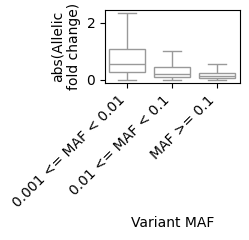

In [4]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

sns.boxplot(x='binned_log10(maf)', y='abs_afc', ax=ax, data=afc, showfliers=False, color='white')
ax.set_xlabel('Variant MAF')
ax.set_ylabel('abs(Allelic\nfold change)')
rotate_xticklabels(ax)


fig.tight_layout()
fig.savefig(f'figures/{PREFIX}png', dpi=300, bbox_inches='tight', facecolor='white')